In [1]:
import numpy as np
import scipy.io as sio 
import scipy.signal as sig
from matplotlib import pyplot as plt
%matplotlib inline
dat1 = sio.loadmat('/Users/soumilhooda/Documents/BCI/Data/BCICIV_4_mat/sub1_comp.mat',struct_as_record = True)
dat2 = sio.loadmat('/Users/soumilhooda/Documents/BCI/Data/BCICIV_4_mat/sub2_comp.mat',struct_as_record = True)
dat3 = sio.loadmat('/Users/soumilhooda/Documents/BCI/Data/BCICIV_4_mat/sub3_comp.mat',struct_as_record = True)

In [10]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import numpy

In [29]:
np.random.seed(0)

In [2]:
# PRE-PROCESSING BLOCK

train_data1 = dat1['train_data']
train_dg1 = dat1['train_dg']
samples1,channels1 = train_data1.shape
tt = 400 #Sampling time
sf = 1000 #Sampling frequency 
channel_data1 = np.transpose(train_data1,(1,0))
finger_data1 = np.transpose(train_dg1,(1,0))

train_data2 = dat2['train_data']
train_dg2 = dat2['train_dg']
samples2,channels2 = train_data2.shape
tt = 400 #Sampling time
sf = 1000 #Sampling frequency 
channel_data2 = np.transpose(train_data2,(1,0))
finger_data2 = np.transpose(train_dg2,(1,0))


train_data3 = dat3['train_data']
train_dg3 = dat3['train_dg']
samples3,channels3 = train_data3.shape
tt = 400 #Sampling time
sf = 1000 #Sampling frequency 
channel_data3 = np.transpose(train_data3,(1,0))
finger_data3 = np.transpose(train_dg3,(1,0))

def bandPass(signal,fl,fh):
    taps = 505
    band = np.array([fl,fh])
    h = sig.firwin(taps,band,fs=sf,pass_zero='bandpass')
    output = np.convolve(signal,h,mode='same')
    return output

def AM(signal,samples):
    cur = 0
    output = []
    for i in range(samples):
        if(i and i % 40 == 0):
            output.append(cur)
            cur = 0
        cur += signal[i]**2
    output.append(cur)
         
    return output

sub_band1 = [bandPass(x,1,60) for x in channel_data1]
gamma_band1 = [bandPass(x,60,100) for x in channel_data1]
fast_gamma_band1 = [bandPass(x,100,200) for x in channel_data1]

sub_band2 = [bandPass(x,1,60) for x in channel_data2]
gamma_band2 = [bandPass(x,60,100) for x in channel_data2]
fast_gamma_band2 = [bandPass(x,100,200) for x in channel_data2]

sub_band3 = [bandPass(x,1,60) for x in channel_data3]
gamma_band3 = [bandPass(x,60,100) for x in channel_data3]
fast_gamma_band3 = [bandPass(x,100,200) for x in channel_data3]


sub_band1 = np.array([AM(x,samples1) for x in sub_band1])
gamma_band1 = np.array([AM(x,samples1) for x in gamma_band1])
fast_gamma_band1 = np.array([AM(x,samples1) for x in fast_gamma_band1])

sub_band2 = np.array([AM(x,samples2) for x in sub_band2])
gamma_band2 = np.array([AM(x,samples2) for x in gamma_band2])
fast_gamma_band2 = np.array([AM(x,samples2) for x in fast_gamma_band2])

sub_band3 = np.array([AM(x,samples3) for x in sub_band3])
gamma_band3 = np.array([AM(x,samples3) for x in gamma_band3])
fast_gamma_band3 = np.array([AM(x,samples3) for x in fast_gamma_band3])

finger_data1_ds = [None]*5
finger_data2_ds = [None]*5
finger_data3_ds = [None]*5
for i in range(5):
    finger_data1_ds[i] = [finger_data1[i][j] for j in range(0,samples1,40)]
    finger_data2_ds[i] = [finger_data2[i][j] for j in range(0,samples2,40)]
    finger_data3_ds[i] = [finger_data3[i][j] for j in range(0,samples3,40)]


dsamples1 = len(finger_data1_ds[0])
dsamples2 = len(finger_data2_ds[0])
dsamples3 = len(finger_data3_ds[0])

states1 = [None]*dsamples1
states2 = [None]*dsamples2
states3 = [None]*dsamples3

threshold_1,threshold_2  = 2.0,1.0

for i in range(dsamples1):
    flex,rest = 0,0
    for j in range(5):
        if finger_data1_ds[j][i] >= threshold_1:
            states1[i] = j + 1
            flex += 1
        elif finger_data1_ds[j][i] < threshold_2:
            rest += 1
    if states1[i] == None:
        if rest:
            states1[i] = 0


for i in range(dsamples2):
    flex,rest = 0,0
    for j in range(5):
        if finger_data2_ds[j][i] >= threshold_1:
            states2[i] = j + 1
            flex += 1
        elif finger_data2_ds[j][i] < threshold_2:
            rest += 1
    if states2[i] == None:
        if rest:
            states2[i] = 0



for i in range(dsamples3):
    flex,rest = 0,0
    for j in range(5):
        if finger_data3_ds[j][i] >= threshold_1:
            states3[i] = j + 1
            flex += 1
        elif finger_data3_ds[j][i] < threshold_2:
            rest += 1
    if states3[i] == None:
        if rest:
            states3[i] = 0




In [15]:
Sub1_SubBand = sub_band1
Sub1_GammaBand = gamma_band1
Sub1_FastGammaBand = fast_gamma_band1
Sub1_FingerState = states1

Sub2_SubBand = sub_band2
Sub2_GammaBand = gamma_band2
Sub2_FastGammaBand = fast_gamma_band2
Sub2_FingerState = states2

Sub3_SubBand = sub_band3
Sub3_GammaBand = gamma_band3
Sub3_FastGammaBand = fast_gamma_band3
Sub3_FingerState = states1

In [16]:
full_band = [AM(x, samples2) for x in channel_data2]

In [17]:
# Zero-less : 
nz_states = []
nz_ch = []
for i in range(len(full_band)):
    cch = []
    for j in range(len(states2)):
        if(states2[j]):
            cch.append(states2[j])
    nz_ch.append(cch)

for s in states2:
    if s:
        nz_states.append(s)

nz_states_np = np.array(nz_states)
nz_ch_np = np.array(nz_ch)

In [18]:
print(nz_states_np.shape)
print(nz_ch_np.shape)

(2258,)
(48, 2258)


In [20]:
nz_ch_np = nz_ch_np.T
print(nz_ch_np.shape)

(2258, 48)


In [21]:
nz_states_np = nz_states_np.reshape(len(nz_states_np), 1)

from sklearn.preprocessing import OneHotEncoder

Fingers_Subject2_OneHot = OneHotEncoder(sparse=False).fit_transform(nz_states_np)
print(Fingers_Subject2_OneHot)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [22]:
from sklearn.preprocessing import Normalizer

Sub2_AllBand = Normalizer().fit(nz_ch_np).transform(nz_ch_np)
print(Sub2_AllBand)

[[0.14433757 0.14433757 0.14433757 ... 0.14433757 0.14433757 0.14433757]
 [0.14433757 0.14433757 0.14433757 ... 0.14433757 0.14433757 0.14433757]
 [0.14433757 0.14433757 0.14433757 ... 0.14433757 0.14433757 0.14433757]
 ...
 [0.14433757 0.14433757 0.14433757 ... 0.14433757 0.14433757 0.14433757]
 [0.14433757 0.14433757 0.14433757 ... 0.14433757 0.14433757 0.14433757]
 [0.14433757 0.14433757 0.14433757 ... 0.14433757 0.14433757 0.14433757]]


In [30]:
model9 = keras.Sequential()
model9.add(layers.Dense(48, input_dim=48, activation='relu'))
model9.add(layers.Reshape(( 1, 48)))
model9.add(layers.LSTM(24, activation = 'relu'))
model9.add(layers.Dense(5, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model9.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model9.summary()

history = model9.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions9 = model9.predict(Sub2_AllBand)
print("Predicted values are: ", predictions9)
np.savetxt('No0State_M9NormalPred.txt',predictions9)
Corrected_Pred9 = numpy.argmax(predictions9, axis = 1)
print(Corrected_Pred9)
np.savetxt('No0State_Pred.txt',Corrected_Pred9)

from sklearn.metrics import accuracy_score
print(accuracy_score(nz_states_np, Corrected_Pred9))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 48)                2352      
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 48)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 24)                7008      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 125       
Total params: 9,485
Trainable params: 9,485
Non-trainable params: 0
_________________________________________________________________
Train on 2258 samples
Epoch 1/10
2258/2258 [==============================] - 11s 5ms/sample - loss: 1.5951 - mae: 0.3175 - mse: 0.1588
Epoch 2/10
2258/2258 [==============================] - 13s 6ms/sample - loss: 1.5927 - mae: 0.3167 - mse: 0.1586


[[  0 479   0   0   0]
 [  0 450   0   0   0]
 [  0 601   0   0   0]
 [  0 388   0   0   0]
 [  0 340   0   0   0]]


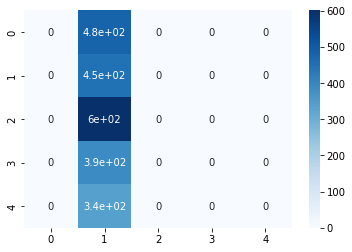

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf9 = confusion_matrix(nz_states_np, Corrected_Pred9)
sns.heatmap(conf9, annot=True, cmap='Blues')
plt.show()

In [34]:
Sub2_AllBand = Sub2_AllBand.reshape(len(Sub2_AllBand),1,len(Sub2_AllBand[0]))
print(Sub2_AllBand.shape)

(2258, 1, 48)


In [42]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import numpy

model = keras.Sequential()
model.add(layers.LSTM(24,  input_shape=(1,48),activation = "relu"))
model.add(layers.Dense(5, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mse'])
model.summary()

history = model.fit(Sub2_AllBand, Fingers_Subject2_OneHot, batch_size = 1, epochs=10)

predictions = model.predict(Sub2_AllBand)
print("Predicted values are: ", predictions)
# np.savetxt('DownsampledModel_NorPred.txt',predictions)
Corrected_Pred = numpy.argmax(predictions, axis = 1)
print(Corrected_Pred)
# np.savetxt('DownsampledModel_Pred.txt',Corrected_Pred)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 24)                7008      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 125       
Total params: 7,133
Trainable params: 7,133
Non-trainable params: 0
_________________________________________________________________
Train on 2258 samples
Epoch 1/10
2258/2258 [==============================] - 12s 5ms/sample - loss: 1.5958 - mse: 0.1589
Epoch 2/10
2258/2258 [==============================] - 11s 5ms/sample - loss: 1.5932 - mse: 0.1587
Epoch 3/10
2258/2258 [==============================] - 10s 4ms/sample - loss: 1.5945 - mse: 0.1588
Epoch 4/10
2258/2258 [==============================] - 10s 4ms/sample - loss: 1.5934 - mse: 0.1587
Epoch 5/10
2258/2258 [==============================] - 9s 4ms/sample - loss: 1.5929 - mse: 

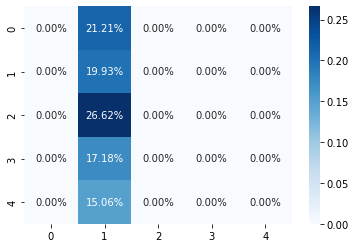

In [43]:
conf = confusion_matrix(nz_states_np, Corrected_Pred)
sns.heatmap(conf/np.sum(conf), annot=True, fmt='.2%', cmap='Blues')
plt.show()